In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

#print('Python', sys.version)

In [2]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features,
                 hidden = 64, layers = 2, output_scale = 0.30):
        super().__init__()
        # Build a simple feed-forward network.
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Start logits near zero so spline softmax is well-behaved.
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context = None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [3]:
def conjure_flow(on_unit_box = True, num_flows = 8, hidden_features = 64, num_bins = 8):
    dim = 2
    transforms = []
    if on_unit_box:
        # Use logit pre-transform to map (0,1) to R.
        transforms.append(InverseTransform(Sigmoid()))

    masks = [torch.tensor([1,0], dtype=torch.bool), torch.tensor([0,1], dtype = torch.bool)]
    for i in range(num_flows):
        mask = masks[i % 2]
        def conditioner(in_features, out_features, _hidden = hidden_features):
            return MLP(in_features, out_features, hidden = _hidden, layers = 2)
        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask                          = mask,
                transform_net_create_fn       = conditioner,
                num_bins                      = num_bins,
                tails                         = "linear",
                tail_bound                    = 5.0,
                apply_unconditional_transform = False,
            )
        )
        transforms.append(RandomPermutation(features = dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape = [dim])
    return Flow(transform, base)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
# Load in Dalitz dataset
mp_thetap = np.load('../data/D_Kspipi_SDP_1e7.npy')

In [20]:
# Load the amplitude model

"""
--- MODEL 5 (The Champion)
# Hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Training details
batch_size = 50000
epochs = 130
scheduler: ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)
learning_rate_init = 0.009
patience = 3
factor = 0.9
min_learning_rate = 1e-6

NLL loss minimum (at the end of training): -1.253 (-1.254 global minimum during training)
Total parameters: 315768
"""

# Model hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Print total number of parameters
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total # of parameters: {total_params}")

# Initialize the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Load the weights
flow.load_state_dict(torch.load('INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model5.pth'))

# Set the flow to evaluation mode
flow.eval()

Total # of parameters: 315768


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (4): Rand

In [7]:
flow.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
flow.to(device)

# Samples to generate
n_samples = 1_000_000

with torch.no_grad():
    mp_thetap_gen = flow.sample(n_samples).cpu().numpy()

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


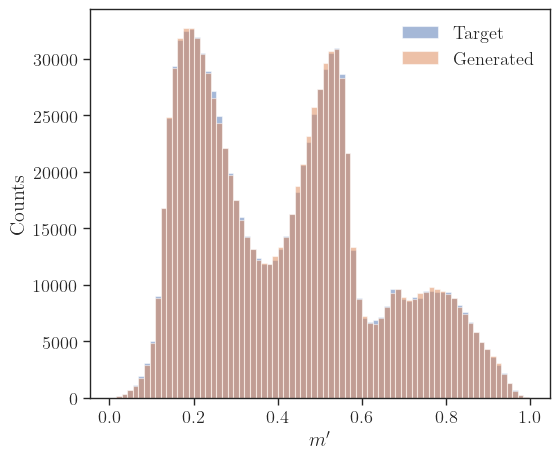

In [8]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 75, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

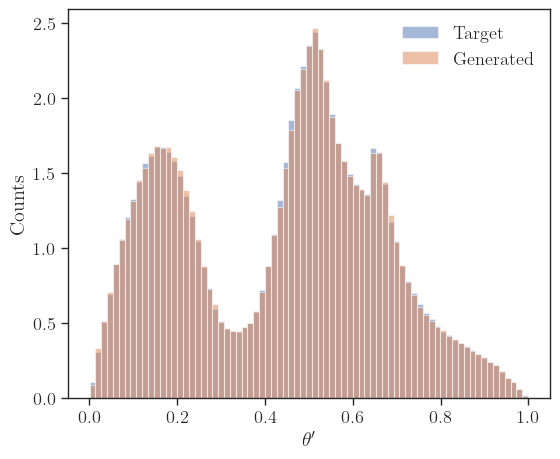

In [9]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 75, alpha = 0.5, label = r'$\mathrm{Target}$', density = True)
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )

#ax.text(0.6, 0.8, rf'$\texttt{{K}} = {K}$ \\ $\texttt{{N\_{{samples}}}} = {N}$ \\ $\texttt{{epochs}} = {epochs}$ \\ $\texttt{{N\_{{blocks}}}} = {n_blocks}$', transform=ax.transAxes, fontsize = 10)

ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

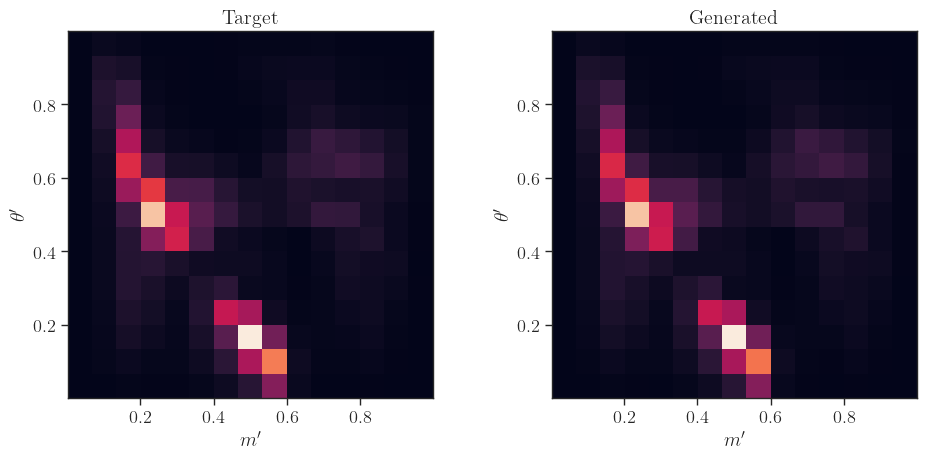

In [16]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 15, rasterized=True)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges], rasterized=True)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

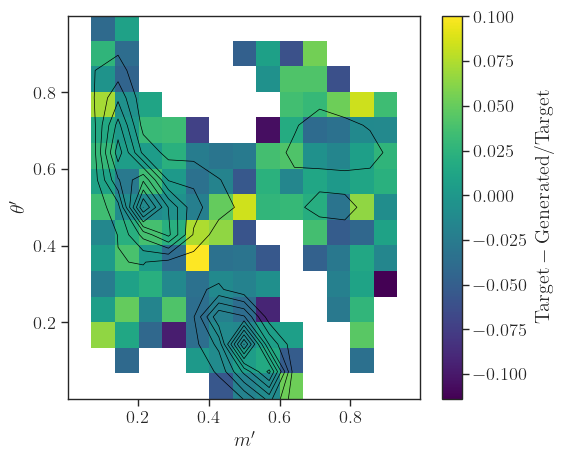

In [18]:
# Plot the per bin chi2 difference ignore bins with 0 entries
fig, ax = plt.subplots( figsize=(6,5) )
h_diff = (h_sim - h_gen) / h_sim
# Get rid of bins with counts less than 1000
h_diff[h_sim < 1000] = None
# Get rid of outliers
#h_diff[h_diff > 0.2] = 0.2
#h_diff[h_diff < -0.2] = -0.2
#h_diff = np.nan_to_num(h_diff)
im = ax.imshow(h_diff.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
#ax.set_xlim(0, 0.4)
#ax.set_ylim(0.4, 0.5)
fig.colorbar(im, ax=ax, label = r'$\mathrm{Target - Generated / Target}$')
# Overlay a contour of the target distribution
ax.contour(h_sim.T, levels=10, colors='black', linewidths=0.5, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_per_bin_diff.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [21]:
@torch.no_grad()
def marginal_likelihood(flow, axis = 0, xs = None, nx = 400, ny = 800, 
                        on_unit_box = True, eps = 1e-8, data_range = None, 
                        batch = 65536, device = None):
    """
    Compute the "exact" marginal distribution learned by the flow along one axis.

    Arguments:
    flow: nflows.flows.Flow object
    axis: which axis to project out (0 or 1)
    xs: if provided, use these x values (np.ndarray of shape (nx,))
    nx: if xs is None, number of points along the projected axis
    ny: number of points along the marginalized axis
    on_unit_box: whether the flow was trained on [0,1]^2
    eps: if on_unit_box, avoid infinities by integrating over [eps, 1-eps]
    data_range: if not on_unit_box, the (min,max) for each axis; if None, uses [-3,3]
    batch: eval batch size for flow.log_prob
    device: torch device (default: "cuda" if available else "cpu")

    Returns:
    xs: np.ndarray of shape (nx,)
    log_marg: np.ndarray of shape (nx,)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # --- grids in DATA space ---
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    if xs is None:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
    else:
        xs = np.asarray(xs, dtype=np.float32)
        nx = xs.shape[0]

    ys = np.linspace(ymin, ymax, ny, dtype=np.float32)

    # Build full grid for evaluation: (ny * nx, 2)
    if axis == 0:
        XX = np.tile(xs, (ny, 1))                  # shape (ny, nx)
        YY = np.tile(ys[:, None], (1, nx))         # shape (ny, nx)
    else:
        XX = np.tile(ys[:, None], (1, nx))         # integrate over x if axis==1
        YY = np.tile(xs, (ny, 1))

    grid = np.stack([XX.ravel(), YY.ravel()], axis=1).astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)

    # Evaluate log p(x) on the grid (batched to be memory-safe)
    outs = []
    for i in range(0, grid_t.shape[0], batch):
        outs.append(flow.log_prob(grid_t[i:i+batch]))
    logp = torch.cat(outs, dim=0).view(ny, nx)     # reshape so axis 0 is the marginalized dim

    # Numerical integral: log \int p(x,y) dy ~ logsumexp_y [ log p(x,y) ] + log \Delta y
    dy = (ymax - ymin) / (ny - 1)
    log_marg = torch.logsumexp(logp, dim=0) + torch.log(torch.tensor(dy, device=device))

    # Return 1d grid and marginal likelihood
    return xs, np.exp(log_marg.detach().cpu().numpy())

In [22]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp         = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


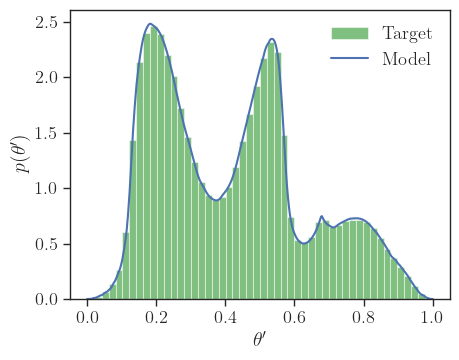

In [25]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:2_000_000,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'green')
# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')

ax.legend(loc = 'best', frameon = False)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

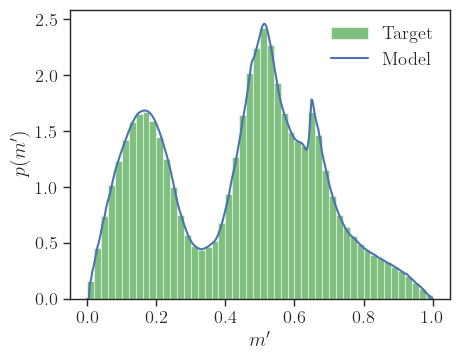

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:2_000_000,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'green')
# Plot model likelihood
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')

ax.legend(loc='best', frameon=False)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

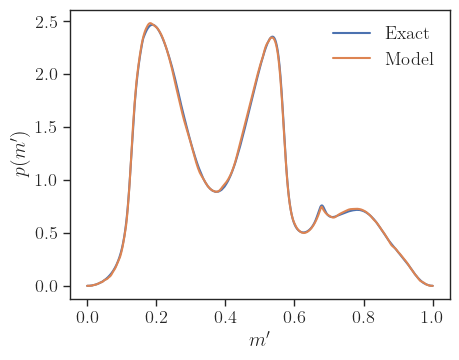

In [27]:
# Compare with the exact likelihood from the amplitude model
mprime_exact = np.load('../data/D_Kpipi_mprime.npy')
dens_m = np.load('../data/D_Kpipi_mprime_marginal.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot exact likelihood
ax.plot(mprime_exact, dens_m, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

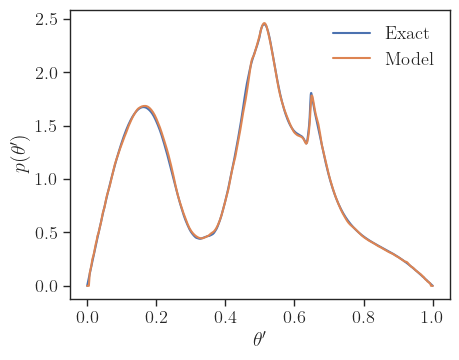

In [28]:
# Compare with the exact likelihood from the amplitude model
thetaprime_exact = np.load('../data/D_Kpipi_thetaprime.npy')
dens_thetaprime = np.load('../data/D_Kpipi_thetaprime_marginal.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot exact likelihood
ax.plot(thetaprime_exact, dens_thetaprime, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
@torch.no_grad()
def conditional_pdf(flow, fixed_value, fixed_axis = 0, nx = 400, on_unit_box = True,
                    eps=1e-8, data_range=None, device=None):
    """
    Compute conditional density p(x | y = y_fixed).

    Args:
        flow         (nflows.flows.Flow): trained flow
        fixed_value (float): value to fix the conditional variable to
        fixed_axis  (int): which axis to fix -- 0 gives p(thetaprime | mprime), 1 gives p(mprime | thetaprime)
        nx          (int): number of points along the free variable
        on_unit_box (bool): whether the flow was trained on [0,1]^2
        eps         (float): if on_unit_box, avoid infinities by integrating over [eps, 1-eps]
        data_range  (tuple): if not on_unit_box, the (min,max) for each axis; if None, uses [-3,3]
        device      (torch.device): device to use (default: "cuda" if available else "cpu")

    Returns:
        xs   (np.ndarray): grid values of the free variable
        pdf  (np.ndarray): normalized conditional density over xs
        logp (np.ndarray): unnormalized log joint for inspection
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # Ranges.
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    # Grid over the free variable.
    if fixed_axis == 0:
        xs = np.linspace(ymin, ymax, nx, dtype=np.float32)
        pts = np.stack([np.full_like(xs, fixed_value, dtype=np.float32), xs], axis=1)
    else:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
        pts = np.stack([xs, np.full_like(xs, fixed_value, dtype=np.float32)], axis=1)

    pts_t = torch.from_numpy(pts).to(device)

    # joint log-prob for each slice point
    logp = flow.log_prob(pts_t).cpu().numpy()
    pdf = np.exp(logp - logp.max())             # Stabilize
    pdf /= np.trapz(pdf, xs)                    # Normalize to 1 (np.trapz is deprecated for numpy > v2.0)
    #pdf /= np.trapezoid(pdf, xs)                # Normalize to 1

    return xs, pdf, logp

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


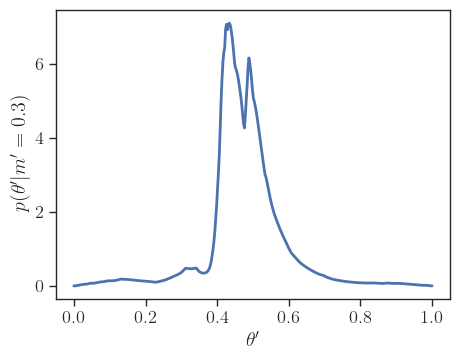

In [32]:
# Compute p(thetaprime | mprime = 0.3)
xs, pdf, _ = conditional_pdf(flow, fixed_value=0.3, fixed_axis=0, nx=400, on_unit_box=True)

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot the conditional density
ax.plot(xs, pdf, lw = 2)

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta' | m'=0.3)$")
fig.tight_layout()

In [35]:
# Map m' -> m12 and s12
def mprime_to_m12(mprime, mmin, mmax):
    """
    CLEO/BaBar/Belle convention: m'(0)=mmax, m'(1)=mmin.
    """
    dM = mmax - mmin
    return mmin + 0.5 * dM * (1.0 + np.cos(np.pi * mprime))

# Map theta' -> s13 along the kinematic arc at fixed s12
def thetap_to_s13(thetap, s13min, s13max):
    # Now θ'=0 -> s13min, θ'=1 -> s13max (increasing order)
    return 0.5 * (s13max + s13min) - 0.5 * (s13max - s13min) * np.cos(np.pi * thetap)

# Full Jacobian |\partial(s12,s13)/\partial(m',\theta')|
def jacobian(mprime, thetap, mmin, mmax, s13min, s13max):
    m12  = mprime_to_m12(mprime, mmin, mmax)
    dM   = (mmax - mmin)
    ds12_dmp  = - np.pi * dM * m12 * np.sin(np.pi * mprime)               # magnitude will be taken
    ds13_dthp = -0.5 * np.pi * (s13max - s13min) * np.sin(np.pi * thetap) # magnitude will be taken
    return np.abs(ds12_dmp) * np.abs(ds13_dthp)

# Kallen function
def kallen(x,y,z):
    return x*x + y*y + z*z - 2*(x*y + x*z + y*z)

# Generic limits: given sij, return sik^{min,max}
def sik_limits_given_sij(sij, M, mi, mj, mk):
    # PDG three-body kinematics (M = parent mass, mi = masses of i,j,k)
    M2 = M*M
    mi2, mj2, mk2 = mi*mi, mj*mj, mk*mk
    s = np.asarray(sij)

    # Central term
    num = (s + mi2 - mj2) * (M2 - s - mk2)
    # Phase-space term
    root = np.sqrt(np.maximum(kallen(s, mi2, mj2) * kallen(M2, s, mk2), 0.0))
    den = 2 * s
    sik_max = mi2 + mk2 + (num + root)/den
    sik_min = mi2 + mk2 + (num - root)/den
    return sik_min, sik_max

In [34]:
def abs_ds13_dthetap(thetap, s13min, s13max):
    # |\partial s13/\partial \theta'| for the square-Dalitz mapping
    return 0.5 * np.pi * (s13max - s13min) * np.abs(np.sin(np.pi * thetap))

def abs_ds12_dmprime(mprime, mmin, mmax):
    # |\partial s12/\partial m'|
    m12 = mprime_to_m12(mprime, mmin, mmax)
    dM  = (mmax - mmin)
    return np.pi * dM * m12 * np.abs(np.sin(np.pi * mprime))

In [38]:
def conditional_theta_given_mprime(amp_obj, mprime, n_theta=400):
    # """
    # Compute conditional PDF of \theta' at fixed m' (slice in \theta') normalized
    # such that \int_0^1 pdf(\theta'|m') d\theta' = 1.

    # Args:
    #     amp_obj   : amplitude object with methods M(), m1(), m2(), m3(), full(pts)
    #     mprime    : fixed m' value (float in [0,1])
    #     n_theta   : number of points in \theta' grid (int)

    # Returns:
    #     thetap_grid (np.ndarray): shape (n_theta,)
    #     pdf_thetap  (np.ndarray): shape (n_theta,)
    # """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # Fixed s12 from m'
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12

    # \theta' grid (uniform is fine; we include the Jacobian below)
    thetap = np.linspace(0.0, 1.0, n_theta)

    # Kinematic limits and map \theta' -> s13(\theta')
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)
    s13 = thetap_to_s13(thetap, s13min, s13max)

    # Evaluate |A|^2 on the slice (m' fixed, \theta' varying)
    pts = np.column_stack([np.full_like(s13, s12), s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density \propto |A|^2 * |\partial s13/\partial \theta'|
    dens = mod2 * abs_ds13_dthetap(thetap, s13min, s13max)

    # Normalize to unit area over \theta'.
    area = np.trapz(dens, thetap)       # np.trapz is deprecated for numpy > v2.0
    #area = np.trapezoid(dens, thetap)
    pdf  = dens / (area + 1e-300)
    return thetap, pdf


def conditional_mprime_given_theta(amp_obj, thetap, n_mprime=400):
    # """
    # Compute conditional PDF of m' at fixed \theta' (slice in m') normalized
    # such that \int_0^1 pdf(m'|\theta') dm' = 1.

    # Args:
    #     amp_obj   : amplitude object with methods M(), m1(), m2(), m3(), full(pts)
    #     thetap    : fixed \theta' value (float in [0,1])
    #     n_mprime  : number of points in m' grid (int)

    # Returns:
    #     mprime_grid (np.ndarray): shape (n_mprime,)
    #     pdf_mprime  (np.ndarray): shape (n_mprime,)
    # """

    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # m' grid (uniform; include |\partial s12 / \partial m'| Jacobian below)
    mprime = np.linspace(0.0, 1.0, n_mprime)

    # For each m', build s12(m') and s13(\theta' ; s12)
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)  # vectorized over m'
    s13 = thetap_to_s13(thetap, s13min, s13max)

    # Evaluate |A|^2 on the slice (\theta' fixed, m' varying)
    pts = np.column_stack([s12, s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density \propto |A|^2 * |\partial s12 / \partial m'|
    dens = mod2 * abs_ds12_dmprime(mprime, mmin, mmax)

    # Normalize to unit area over m'.
    area = np.trapz(dens, mprime)       # np.trapz is deprecated for numpy > v2.0
    #area = np.trapezoid(dens, mprime)
    pdf  = dens / (area + 1e-300)
    return mprime, pdf

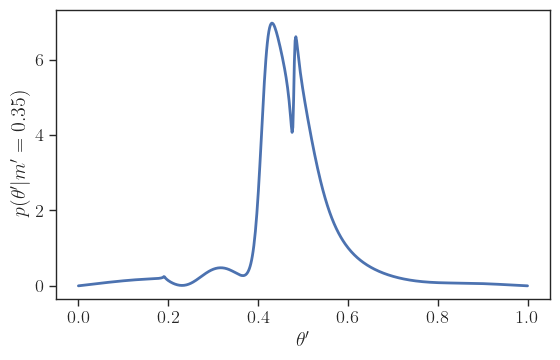

In [40]:
# Import the amplitude model for on-the-fly conditional extraction
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../data_gen")))
from DKpp import DKpp

# Initialize amplitude model
dk = DKpp()

# Slice at fixed m' (e.g., m' = 0.35)
thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=0.3, n_theta=600)

# Slice at fixed \theta' (e.g., \theta' = 0.60)
mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=0.20, n_mprime=600)

fig, ax = plt.subplots(1,1,figsize=(6,4))
# Plot the conditional density
ax.plot(thp, p_th_given_m, lw=2)

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m'=0.35)$")
fig.tight_layout()

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


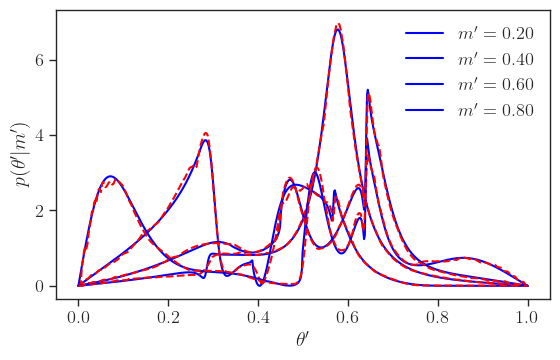

In [41]:
# Define and compare a set of m' slices between exact and flow
mprime_slices = np.linspace(0.2, 0.8, 4)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for mprime in mprime_slices:
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime, n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.5, label = rf'$m^\prime = {mprime:.2f}$', color = 'blue')

    # Compute the model conditional
    xs, pdf, _ = conditional_pdf(flow, fixed_value=mprime, fixed_axis=0, nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5, color = 'red')

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m')$")
ax.legend(loc='best', frameon=False)
fig.tight_layout()

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


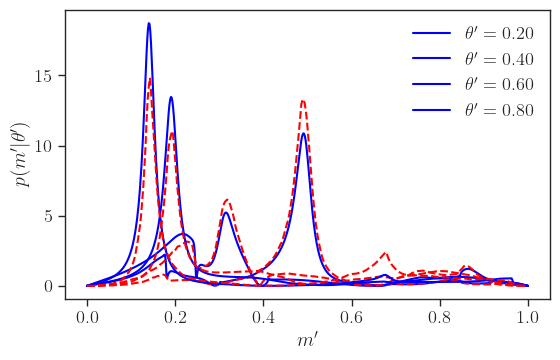

In [42]:
# Define and compare a set of \theta' slices between exact and flow
thetap_slices = np.linspace(0.2, 0.8, 4)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for thetap in thetap_slices:
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap, n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.5, label = rf'$\theta^\prime = {thetap:.2f}$', color = 'blue')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap, fixed_axis=1, nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5, color = 'red')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$p(m'|\theta')$")
ax.legend(loc='best', frameon=False)
fig.tight_layout()

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


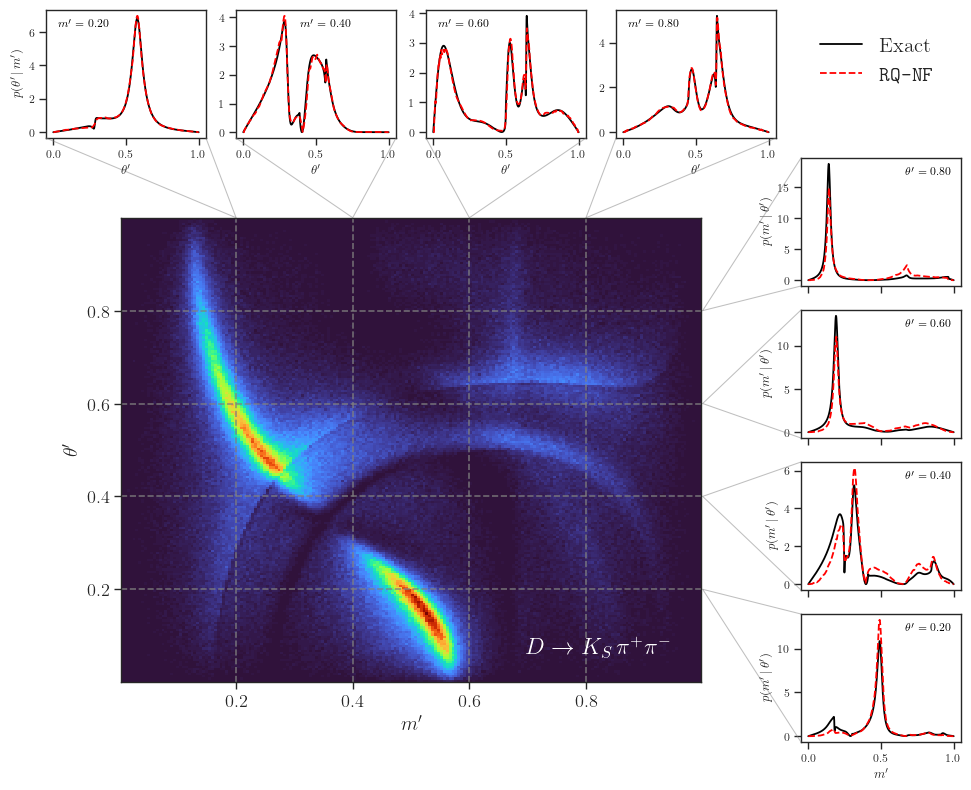

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch

# Layout parameters
n_top    = 4   # number of top subplots
n_right  = 4   # number of right subplots

# Main panel position [left, bottom, width, height] in figure fractions
MAIN = [0.12, 0.12, 0.58, 0.58]

# Top-strip geometry (subplots are placed manually above MAIN)
TOP_HEIGHT    = 0.16      # height of each top subplot
TOP_BOX_W     = 0.16      # width of each top subplot
TOP_GAP_W     = 0.03      # horizontal gap between top subplots
TOP_GAP_ABOVE = 0.1      # vertical gap between MAIN top and the bottom of the top strip

# Right-strip geometry (subplots placed manually to the right of MAIN)
RIGHT_WIDTH    = 0.16      # width of each right subplot
RIGHT_BOX_H    = 0.16      # height of each right subplot
RIGHT_GAP_H    = 0.03      # vertical gap between right subplots
RIGHT_GAP_SIDE = 0.1      # horizontal gap between MAIN right and the left of the right strip

# Data limits for the main panel (used for connectors only)
m_lim     = (0.0, 1.0)   # x-range (m')
theta_lim = (0.0, 1.0)   # y-range (\theta')

# Build figure (w/ manual positions)
fig = plt.figure(figsize=(10, 8))

# Main axis
ax_main = fig.add_axes(MAIN)
ax_main.set_xlim(*m_lim)
ax_main.set_ylim(*theta_lim)
ax_main.set_xlabel(r"$m^\prime$")
ax_main.set_ylabel(r"$\theta^\prime$")
h_sim, xedges, yedges, _ = ax_main.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 200, rasterized=True, cmap='turbo')
ax_main.text(0.95, 0.05, r'$D \to K_S\,\pi^+ \pi^-$', transform=ax_main.transAxes,
             fontsize=17, color='white', ha='right', va='bottom', weight='bold')

# Place horizontal and vertical dashed lines corresponding to conditionals in top and right subplots
for mp in mprime_slices:
    ax_main.axvline(mp, ls='--', color='gray', lw=1.2, alpha=0.8)
for thp in thetap_slices:
    ax_main.axhline(thp, ls='--', color='gray', lw=1.2, alpha=0.8)

# Compute the horizontal span available above MAIN and center the top strip in that span
main_left, main_bottom, main_w, main_h = MAIN
top_y = main_bottom + main_h + TOP_GAP_ABOVE
top_span_left  = main_left
top_span_right = main_left + main_w
total_top_width = n_top * TOP_BOX_W + (n_top-1) * TOP_GAP_W
top_left0 = top_span_left + 0.5 * (main_w - total_top_width)  # center over MAIN

# Top subplots
top_axes = []
for i in range(n_top):
    left = top_left0 + i*(TOP_BOX_W + TOP_GAP_W)
    ax = fig.add_axes([left, top_y, TOP_BOX_W, TOP_HEIGHT])
    # Typical usage: ax.set_xlim(theta_lim); ax.plot(theta, p_theta_given_m_band)
    ax.tick_params(labelsize=8)
    if i > 0:
        #ax.set_yticklabels([])
        ax.set_xlabel(r"$\theta^\prime$", fontsize=9)
    if i == 0:
        ax.set_ylabel(r"$p(\theta^\prime\,|\,m^\prime)$", fontsize=9)
        ax.set_xlabel(r"$\theta^\prime$", fontsize=9)
    
    # Append the axis
    top_axes.append(ax)

# Compute the vertical span available to the right of MAIN and center the right strip in that span
right_x            = main_left + main_w + RIGHT_GAP_SIDE
right_span_bottom  = main_bottom
right_span_top     = main_bottom + main_h
total_right_height = n_right * RIGHT_BOX_H + (n_right - 1) * RIGHT_GAP_H
right_bottom0      = right_span_bottom + 0.5 * (main_h - total_right_height)

# Right subplots
right_axes = []
for j in range(n_right):
    bottom = right_bottom0 + (n_right-1-j)*(RIGHT_BOX_H + RIGHT_GAP_H)  # top-to-bottom order
    ax = fig.add_axes([right_x, bottom, RIGHT_WIDTH, RIGHT_BOX_H])
    # Typical usage: ax.set_ylim(m_lim); ax.plot(p_m_given_theta_band, m)
    ax.tick_params(labelsize=8)
    if j < n_right - 1:
        ax.set_xticklabels([])
        ax.set_ylabel(r"$p(m^\prime\,|\,\theta^\prime)$", fontsize=9)
    else:
        ax.set_xlabel(r"$m^\prime$", fontsize=9)
        ax.set_ylabel(r"$p(m^\prime\,|\,\theta^\prime)$", fontsize=9)

    # Append the axis
    right_axes.append(ax)

for j, ax in enumerate(right_axes):
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap_slices[-(j+1)], n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.3, label = rf'$\theta^\prime = {thetap_slices[-(j+1)]:.2f}$', color = 'black')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap_slices[-(j+1)], fixed_axis=1,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.3, color = 'red')
    ax.text(0.65, 0.93, rf'$\theta^\prime = {thetap_slices[-(j+1)]:.2f}$', transform=ax.transAxes,
            fontsize=8, color='black', ha='left', va='top')

for j, ax in enumerate(top_axes):
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime_slices[j], n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.3, label = rf'$m^\prime = {mprime_slices[j]:.2f}$', color = 'black')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=mprime_slices[j], fixed_axis=0,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.3, color = 'red')
    if j != 1:
        ax.text(0.075, 0.93, rf'$m^\prime = {mprime_slices[j]:.2f}$', transform=ax.transAxes,
                fontsize=8, color='black', ha='left', va='top')
    else: 
        ax.text(0.4, 0.93, rf'$m^\prime = {mprime_slices[j]:.2f}$', transform=ax.transAxes,
                fontsize=8, color='black', ha='left', va='top')

# Two connectors from each vertical slice to bottom corners of its corresponding top subplot
n_top_use = min(len(mprime_slices), len(top_axes))
for i in range(n_top_use):
    xA = float(mprime_slices[i])
    ax_top = top_axes[i]
    for x_frac in (0.0, 1.0):  # bottom-left and bottom-right corners
        cp = ConnectionPatch(
            xyA=(xA, theta_lim[1]),      coordsA=ax_main.transData,   axesA=ax_main,
            xyB=(x_frac, 0.0),           coordsB=ax_top.transAxes,    axesB=ax_top,
            color='gray', lw=0.75, alpha=0.5, zorder=1000, clip_on=False
        )
        fig.add_artist(cp)

# Two connectors from each horizontal slice to both left corners of its corresponding right subplot
n_right_use = min(len(thetap_slices), len(right_axes))
for j in range(n_right_use):
    # pair the *topmost* horizontal slice with the *topmost* right subplot
    yA = float(thetap_slices[j])
    ax_right = right_axes[-(j+1)]   # reverse the mapping: top slice -> top subplot
    for y_frac in (0.0, 1.0):  # left-bottom and left-top corners
        cp = ConnectionPatch(
            xyA=(m_lim[1], yA),           coordsA=ax_main.transData,  axesA=ax_main,
            xyB=(0.0, y_frac),            coordsB=ax_right.transAxes, axesB=ax_right,
            color='gray', lw=0.75, alpha=0.5, zorder=1000, clip_on=False
        )
        fig.add_artist(cp)

# Add custom legend for top/right subplots.
custom_lines = [Line2D([0], [0], color='black', lw=1.3, ls='-'),
                Line2D([0], [0], color='red', lw=1.3, ls='--')]
fig.legend(custom_lines, [r'$\mathrm{Exact}$', r'$\texttt{RQ-NF}$'], 
           loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=15, frameon=False)

#fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_conditionals.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_conditionals.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [45]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


(-0.12308424711227417, 2.5847691893577576, 0.0, 1.0)

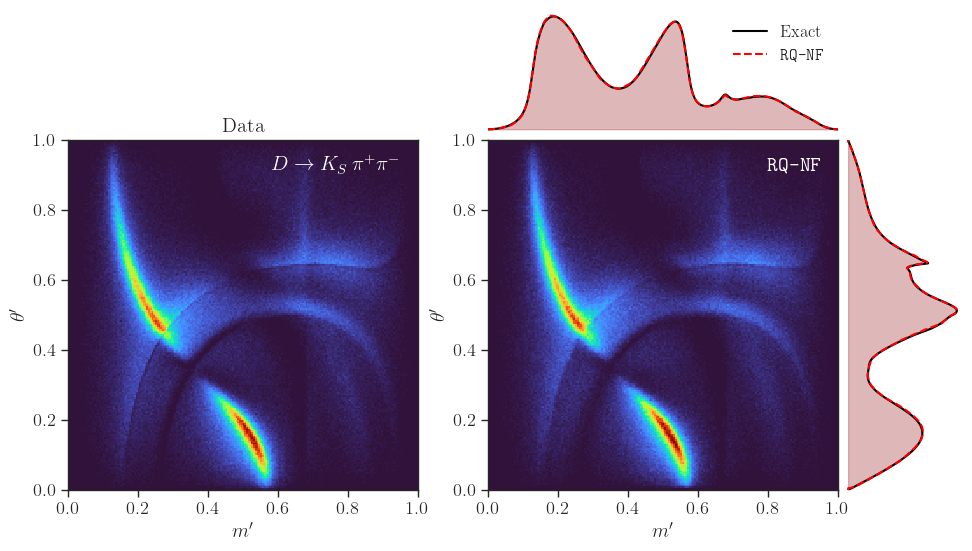

In [46]:
# Position parameters for the joint + marginals layout
LEFT_START   = 0.08   # x-position of left panel
BOTTOM       = 0.12   # y-position (shared by both)
MAIN_WIDTH   = 0.32   # width of each main subplot
MAIN_HEIGHT  = 0.70   # height of each main subplot
MAIN_GAP     = 0.03   # horizontal gap between left and right mains
MARGINAL_GAP = 0.01   # gap between main and marginal axes
TOP_HEIGHT   = 0.25   # height of top marginal
RIGHT_WIDTH  = 0.10   # width of right marginal

# Build main panel positions 
LM = [LEFT_START, BOTTOM, MAIN_WIDTH, MAIN_HEIGHT]
RM = [LEFT_START + MAIN_WIDTH + MAIN_GAP, BOTTOM, MAIN_WIDTH, MAIN_HEIGHT]

# Marginal positions for the right panel
RTOP   = [RM[0], RM[1] + RM[3] + MARGINAL_GAP, RM[2], TOP_HEIGHT]
RRIGHT = [RM[0] + RM[2] + MARGINAL_GAP - 0.02, RM[1], RIGHT_WIDTH, RM[3]]

# Initialize figure
fig = plt.figure(figsize=(12, 5))

# Square Dalitz from "exact" amplitude model (left main)
ax_joint_L = fig.add_axes(LM)
h_sim, xedges, yedges, _ = ax_joint_L.hist2d(mp_thetap[:n_samples, 0], mp_thetap[:n_samples, 1], bins = [np.linspace(0, 1, 201), np.linspace(0, 1, 201)], rasterized=True, cmap='turbo')
ax_joint_L.set_xlabel(r"$m'$")
ax_joint_L.set_ylabel(r"$\theta'$")
ax_joint_L.set_aspect('equal')
ax_joint_L.text(0.95, 0.9, r'$D \to K_S\,\pi^+ \pi^-$', transform=ax_joint_L.transAxes,
                fontsize=15, color='white', ha='right', va='bottom', weight='bold')
ax_joint_L.set_title(r'$\mathrm{Data}$')

# Square Dalitz from RQ-NF model (right main)
ax_joint_R = fig.add_axes(RM)
h_gen, _, _, _ = ax_joint_R.hist2d(mp_thetap_gen[:, 0], mp_thetap_gen[:, 1], bins=[xedges, yedges], rasterized=True, cmap='turbo')

ax_joint_R.set_xlabel(r"$m'$")
ax_joint_R.set_ylabel(r"$\theta'$")
ax_joint_R.set_aspect('equal')
ax_joint_R.text(0.95, 0.9, r'$\texttt{RQ-NF}$', transform=ax_joint_R.transAxes,
                fontsize=15, color='white', ha='right', va='bottom', weight='bold')

# Create marginals
ax_top_R   = fig.add_axes(RTOP)
ax_right_R = fig.add_axes(RRIGHT)

# Make the top marginal exactly match the rendered left/width of ax_joint_R
# (aspect='equal' may shrink/expand the joint's actual width)
left, bottom, width, height = ax_joint_R.get_position().bounds
top_left   = left
top_bottom = RTOP[1]
top_width  = width
top_height = RTOP[3]
ax_top_R.set_position([top_left, top_bottom, top_width, top_height])

# Lock limits to the 2D hist range (prevents autoscale drift)
xmin, xmax = xedges[0], xedges[-1]
ymin, ymax = yedges[0], yedges[-1]
ax_joint_R.set_xlim(xmin, xmax)
ax_joint_R.set_ylim(ymin, ymax)

ax_top_R.set_xlim(xmin, xmax)
ax_top_R.set_autoscalex_on(False)
ax_top_R.margins(x=0)

ax_right_R.set_ylim(ymin, ymax)
ax_right_R.set_autoscaley_on(False)
ax_right_R.margins(y=0)


# Assume xmin, xmax, ymin, ymax already set; limits locked; positions adjusted

# Top marginal p(m′) = \int p(\theta^\prime\,|\,m^\prime) d\theta^\prime (comparison between exact and model)
mask_exact_x = (mprime_exact >= xmin) & (mprime_exact <= xmax)
mask_model_x = (thetap       >= xmin) & (thetap       <= xmax)

# Fill under the exact density
ax_top_R.fill_between(mprime_exact[mask_exact_x],
                      dens_m[mask_exact_x],
                      0, color='black', alpha=0.15, zorder=1)
# Plot exact density
ax_top_R.plot(mprime_exact[mask_exact_x],
              dens_m[mask_exact_x], color='black', lw=1.5, zorder=2, label=r'$\mathrm{Exact}$')

# Fill under the model density
ax_top_R.fill_between(thetap[mask_model_x],
                      pthetap[mask_model_x],
                      0, color='red', alpha=0.15, zorder=1)
# Plot model density
ax_top_R.plot(thetap[mask_model_x],
              pthetap[mask_model_x], '--', color='red', lw=1.5, zorder=2, label=r'$\texttt{RQ-NF}$')

# Keep top marginal clean (no axes)
ax_top_R.set_xlim(xmin, xmax)
ax_top_R.axis('off')
ax_top_R.legend(loc='upper right', fontsize=12, frameon=False)

# Right marginal p(θ′) = \int p(m′\,|\,θ′) dm′ (comparison between exact and model)
mask_exact_y = (thetaprime_exact >= ymin) & (thetaprime_exact <= ymax)
mask_model_y = (mp               >= ymin) & (mp               <= ymax)

# Fill under the exact density
ax_right_R.fill_betweenx(thetaprime_exact[mask_exact_y],
                         0, dens_thetaprime[mask_exact_y],
                         color='black', alpha=0.15, zorder=1)
# Plot exact density
ax_right_R.plot(dens_thetaprime[mask_exact_y],
                thetaprime_exact[mask_exact_y], color='black', lw=1.5, zorder=2)

# Fill under the model density
ax_right_R.fill_betweenx(mp[mask_model_y],
                         0, pmp[mask_model_y],
                         color='red', alpha=0.15, zorder=1)
# Plot model density
ax_right_R.plot(pmp[mask_model_y],
                mp[mask_model_y], '--', color='red', lw=1.5, zorder=2)

# Keep right marginal clean (no axes)
ax_right_R.set_ylim(ymin, ymax)
ax_right_R.axis('off')

#fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_marginals.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_marginals.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')